In [17]:
import open3d
from moseq2_detectron_extract.io.session import Session, Stream
from moseq2_detectron_extract.proc.proc import prep_raw_frames, clean_frames, get_frame_features, colorize_video, apply_roi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import copy
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import cv2



In [63]:
def frames_to_point_cloud(frames, ignore_zeros=True, invert=True):
    if invert:
        norm = np.nanmax(frames)
    else:
        norm = np.nanmin(frames)
    print(norm)
    xyz = []
    if len(frames.shape) == 3:
        for k in range(frames.shape[0]):
            for i in range(frames.shape[1]):
                for j in range(frames.shape[2]):
                    if ignore_zeros and frames[k, i, j] == 0:
                        continue
                    xyz.append([i, j, frames[k, i, j] - norm])
    elif len(frames.shape) == 2:
        for i in range(frames.shape[0]):
            for j in range(frames.shape[1]):
                if ignore_zeros and frames[i, j] == 0:
                    continue
                xyz.append([i, j, frames[i, j] - norm])
    else:
        raise ValueError("Expected `frames` to be either 2D or 3D!")
    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(xyz)
    return pcd

In [ ]:
#session = Session(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Abraira_Lab\Spinal_Cord_Injury-C57BL6\11_animal_subset\session_20200814144734.tar.gz")
session = Session(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Dulin_Lab\DREADDs Cohort- Ashley Tucker\Week 9 Post Transplantation Post CNO\session_20220819105327.tar.gz")
first_frame, bground_im, roi, true_depth = session.find_roi()

In [7]:
frame_idx, raw_frames = next(session.sample(1000))
preped_frame = prep_raw_frames(raw_frames,
                               #bground_im=session.bground_im,
                               roi=session.roi,
                               #vmin=0,
                               #vmax=100)
)


PointCloud with 61005000 points.

647.0 711.0


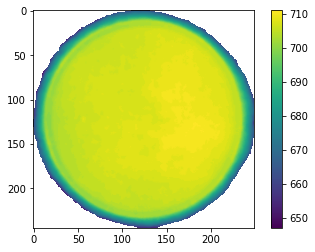

In [55]:
bkg = apply_roi(bground_im[None, :,:], roi)[0]
zeros = bkg == 0
bkg[zeros] = np.nan
print(np.nanmin(bkg), np.nanmax(bkg))
plt.imshow(bkg)
plt.colorbar()

In [77]:
bkg.shape

(245, 249)

In [ ]:
background_pcd = frames_to_point_cloud(apply_roi(bground_im[None, :,:], roi))
open3d.visualization.draw_geometries([background_pcd])

In [96]:
background_pcd.estimate_normals()
background_hull, densities =  open3d.geometry.TriangleMesh.create_from_point_cloud_poisson(background_pcd, depth=10)

all_verts = np.asarray(background_hull.vertices)
verts_to_remove = []
for vi, vert in enumerate(all_verts):
    y = int(np.floor(vert[0]))
    x = int(np.floor(vert[1]))
    #print(y, xbkg[y, x])
    if y >= bkg.shape[0] or y < 0 \
    or x >= bkg.shape[1] or x < 0 \
    or np.isnan(bkg[y, x]):
        verts_to_remove.append(vi)
background_hull.remove_vertices_by_index(verts_to_remove)

#background_hull.orient_normals_towards_camera_location(background_hull.get_center())
#background_hull.normals = open3d.utility.Vector3dVector( - np.asarray(background_hull.normals))
#background_hull =  open3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(background_pcd, alpha=30)
#background_hull =  open3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(background_pcd, open3d.utility.DoubleVector([0.5, 1.0, 2.0, 4.0, 8.0, 16, 32]))



# triangle_clusters, cluster_n_triangles, cluster_area = (background_hull.cluster_connected_triangles())
# triangle_clusters = np.asarray(triangle_clusters)
# cluster_n_triangles = np.asarray(cluster_n_triangles)
# cluster_area = np.asarray(cluster_area)
# background_hull_0 = copy.deepcopy(background_hull)
# triangles_to_remove = cluster_n_triangles[triangle_clusters] < 100
# background_hull_0.remove_triangles_by_mask(triangles_to_remove)

# background_hull = background_hull_0


background_hull = background_hull.filter_smooth_simple(number_of_iterations=5)
#background_hull = open3d.t.geometry.TriangleMesh.from_legacy(background_hull).fill_holes(100).to_legacy()
#vertices_to_remove = densities < np.quantile(densities, 0.3)
#hull.remove_vertices_by_mask(vertices_to_remove)

background_hull.compute_vertex_normals()
background_hull.vertex_normals = open3d.utility.Vector3dVector( - np.asarray(background_hull.vertex_normals))

open3d.visualization.draw_geometries([background_hull, background_pcd])
open3d.visualization.draw_geometries([background_hull])